# Contenidos

1. [Introducción](#Introducción)
    - Explicación general del código

2. [Importación de Paquetes](#Importación-de-Paquetes)
    - Importación de librerías

3. [Carga de Datos](#Carga-de-Datos)
    - Descripción de los Datos
    - Exploración Inicial

4. [Preprocesamiento de Datos](#Preprocesamiento-de-Datos)
    - Limpieza de Datos
    - Transformación de Variables Categóricas
    - Escalado de Variables Numéricas
    - Balanceo del Dataset con SMOTE

5. [División del Conjunto de Datos](#División-del-Conjunto-de-Datos)
    - División en Entrenamiento y Prueba

6. [Modelado](#Modelado)
    - Modelos Implementados
        - Regresión Logística
        - Random Forest
        - Máquina de Soporte Vectorial (SVM)
        - K-Nearest Neighbors (KNN)
        - XGBoost

7. [Evaluación de Modelos](#Evaluación-de-Modelos)
    - Métricas de Desempeño
    - Análisis Comparativo de Modelos
    - Selección del Mejor Modelo

8. [Visualización de Resultados](#Visualización-de-Resultados)
    - Comparación de Métricas
    - Gráficos de Rendimiento

9. [Conclusión y Recomendaciones](#Conclusión-y-Recomendaciones)

10. [Referencias](#Referencias)

# Introducción

Este código realiza el preprocesamiento de datos, implementa SMOTE para balancear el conjunto de datos, entrena varios modelos de Machine Learning, calcula métricas de desempeño, y genera una tabla y gráficos comparativos de los modelos:

### Explicación:

1. **Preprocesamiento de datos:**
   - Se eliminan columnas irrelevantes (`zipCodeOrigin`, `zipMerchant`).
   - Se transforman las columnas categóricas en valores numéricos con `LabelEncoder`.
   - Se escala el monto de las transacciones para normalizar los datos.

2. **Balanceo del conjunto de datos:**
   - Se utiliza SMOTE para balancear las clases en el conjunto de datos.

3. **Entrenamiento de modelos:**
   - Se entrenan cinco modelos: Regresión Logística, Bosques Aleatorios, Máquina de Soporte Vectorial, XGBoost, y K-Nearest Neighbors.

4. **Cálculo de métricas:**
   - Se calculan métricas de desempeño como `F1-Score`, `Recall`, `Precisión`, `AUC`, y `Exactitud`.

5. **Comparación de modelos:**
   - Se genera una tabla y gráficos para comparar el desempeño de los modelos y determinar el mejor.

### Salida esperada:
- Una tabla que clasifica los modelos de mejor a peor basado en `F1-Score`.
- Gráficos que ilustran la comparación de las métricas y el ranking de los modelos.

# Importación de Paquetes

In [63]:
# carga, lectura y procesamiento
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
import os
import json

# Modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import joblib

# Metricas
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de Datos

In [64]:
# Cargar los datos usando una ruta relativa desde notebooks
data = pd.read_csv('../data/banksim.csv')

# Mostrar las primeras filas para verificar la carga
data.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


**Descripción del conjunto de datos:**
Se tienen 9 variables y la variable objetivo:

| **Columna**       | **Descripción**                                                                                                         | **Tipo de Datos** | **Valores/Notas**                                                                                   |
|-------------------|-------------------------------------------------------------------------------------------------------------------------|-------------------|------------------------------------------------------------------------------------------------------|
| **Step**          | Representa el día desde el inicio de la simulación. La simulación tiene 180 pasos, lo que equivale a 6 meses virtuales. En otras palabras son los días desde el inicio de la simulación. | Numérico          | 1-180                                                                                               |
| **Customer**      | Identificador único para cada cliente.                                                                                  | Texto             | Ejemplo: 'C1093826151'                                                                               |
| **zipCodeOrigin** | Código postal del origen o fuente de la transacción.                                                                     | Numérico          | Código postal de 5 dígitos                                                                           |
| **Merchant**      | Identificador único del comerciante.                                                                                     | Texto             | Ejemplo: 'M348934600'                                                                                |
| **zipMerchant**   | Código postal del comerciante.                                                                                           | Numérico          | Código postal de 5 dígitos                                                                           |
| **Age**           | Edad categorizada del cliente.                                                                                           | Numérico          | 0: <= 18, 1: 19-25, 2: 26-35, 3: 36-45, 4: 46-55, 5: 56-65, 6: > 65, U: Desconocido                   |
| **Gender**        | Género del cliente.                                                                                                      | Texto             | E: Empresa, F: Femenino, M: Masculino, U: Desconocido                                                |
| **Category**      | Categoría de la compra realizada.                                                                                        | Texto             | Ejemplo: 'es_transportation', 'es_health', etc.                                                      |
| **Amount**        | Monto de la transacción realizada.                                                                                       | Numérico          | Ejemplo: 4.55                                                                                        |
| **Fraud**         | Variable objetivo que indica si la transacción es fraudulenta (1) o benigna (0).                                          | Binario           | 1: Fraudulenta, 0: No fraudulenta                                                                    |

# Preprocesamiento de Datos

In [65]:
## Eliminar columnas con un único valor
#Problemas al incluirlas:
#Los identificadores únicos no aportan patrones estadísticos significativos.
#Influyen en el cálculo de métricas como correlaciones y pueden introducir ruido en el modelo.
#Si se incluyen en un modelo predictivo, pueden llevar al sobreajuste, ya que el modelo puede memorizar los valores específicos de clientes o comerciantes.
# aunque step no es propiamente un identificador genera el mismo efecto como no es propiamente una fecha no prmite identificar patrones temporales (ejemplo: estacionalidades)
data.drop(columns=['step', 'zipcodeOri', 'zipMerchant', 'customer', 'merchant'], inplace=True)

## Convertir variables categóricas en valores numéricos
label_encoders = {}
categorical_columns = ['category', 'gender', 'age']

for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

## Escalar las variables numéricas
scaler = StandardScaler()
data[['amount']] = scaler.fit_transform(data[['amount']])

In [66]:
data.head()

,age,gender,category,amount,fraud
0,4,2,12,-0.299276,0
1,2,2,12,0.016067,0
2,4,1,12,-0.098742,0
3,3,2,12,-0.185275,0
4,5,2,12,-0.019480,0


In [67]:
# Después de ejecutar el bucle donde se aplica LabelEncoder, se puede iterar sobre el diccionario label_encoders para imprimir los valores categóricos y sus etiquetas numéricas correspondientes:
for column, encoder in label_encoders.items():
    if column not in["customer", "merchant"]: #no mostar las etiquetas de identificadores unicos que puede ser extensa
        print(f"Etiquetas para la columna '{column}':")
        for idx, value in enumerate(encoder.classes_):
            print(f"  {value} -> {idx}")


Etiquetas para la columna 'category':
  'es_barsandrestaurants' -> 0
  'es_contents' -> 1
  'es_fashion' -> 2
  'es_food' -> 3
  'es_health' -> 4
  'es_home' -> 5
  'es_hotelservices' -> 6
  'es_hyper' -> 7
  'es_leisure' -> 8
  'es_otherservices' -> 9
  'es_sportsandtoys' -> 10
  'es_tech' -> 11
  'es_transportation' -> 12
  'es_travel' -> 13
  'es_wellnessandbeauty' -> 14
Etiquetas para la columna 'gender':
  'E' -> 0
  'F' -> 1
  'M' -> 2
  'U' -> 3
Etiquetas para la columna 'age':
  '0' -> 0
  '1' -> 1
  '2' -> 2
  '3' -> 3
  '4' -> 4
  '5' -> 5
  '6' -> 6
  'U' -> 7


In [68]:
# guardar este mapeo en un diccionario para referencia futura:
label_mappings = {
    column: dict(zip(encoder.classes_, range(len(encoder.classes_))))
    for column, encoder in label_encoders.items()
}

print(label_mappings)


{'category': {"'es_barsandrestaurants'": 0, "'es_contents'": 1, "'es_fashion'": 2, "'es_food'": 3, "'es_health'": 4, "'es_home'": 5, "'es_hotelservices'": 6, "'es_hyper'": 7, "'es_leisure'": 8, "'es_otherservices'": 9, "'es_sportsandtoys'": 10, "'es_tech'": 11, "'es_transportation'": 12, "'es_travel'": 13, "'es_wellnessandbeauty'": 14}, 'gender': {"'E'": 0, "'F'": 1, "'M'": 2, "'U'": 3}, 'age': {"'0'": 0, "'1'": 1, "'2'": 2, "'3'": 3, "'4'": 4, "'5'": 5, "'6'": 6, "'U'": 7}}


In [69]:
## Definir variables independientes y dependientes
X = data.drop(columns=['fraud'])  # Variables independientes
y = data['fraud']  # Variable objetivo

In [70]:
## Balancear el conjunto de datos con SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Contar registros por clase en y_balanced
class_counts = Counter(y_balanced)

# Imprimir los resultados
for label, count in class_counts.items():
    print(f"Clase {label}: {count} registros")

Clase 0: 587443 registros
Clase 1: 587443 registros


# División del Conjunto de Datos

In [71]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Modelado

In [72]:
# Modelos a evaluar
modelos = {
    "Regresión Logística": LogisticRegression(),
    "Bosques Aleatorios": RandomForestClassifier(verbose=1, class_weight="balanced"),
    #"Máquina de Soporte Vectorial": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

# Hiperparámetros optimizados para mayor rapidez
hiperparametros = {
    "Regresión Logística": {"C": [0.1, 1], "solver": ["liblinear"]},  
    "Bosques Aleatorios": {"n_estimators": [50, 100], "max_depth": [10, None]},  
    #"Máquina de Soporte Vectorial": {"C": [0.1, 1], "kernel": ["linear"]},  
    "K-Nearest Neighbors": {"n_neighbors": [3, 5], "weights": ["uniform"]},  
    "XGBoost": {"n_estimators": [50, 100], "learning_rate": [0.1]}  
}

# Lista para almacenar los mejores hiperparámetros y resultados
mejores_hiperparametros = []
resultados = []

for nombre, modelo in modelos.items():
    print(f"Entrenando: {nombre}")
    
    # Configurar GridSearchCV
    grid = GridSearchCV(
        estimator=modelo, 
        param_grid=hiperparametros[nombre], 
        scoring='f1', 
        cv=2,  # Reducir a 2 folds para rapidez
        n_jobs=-1  # Usar múltiples núcleos
    )
    
    # Entrenar el modelo
    grid.fit(X_train, y_train)
    
    # Obtener el mejor modelo y sus hiperparámetros
    mejor_modelo = grid.best_estimator_
    mejores_params = grid.best_params_
    mejores_hiperparametros.append({"Modelo": nombre, "Mejores Hiperparámetros": mejores_params})
    
    # Predicciones con el mejor modelo
    y_pred = mejor_modelo.predict(X_test)
    y_prob = mejor_modelo.predict_proba(X_test)[:, 1] if hasattr(mejor_modelo, "predict_proba") else None
    
    # Calcular métricas
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    accuracy = accuracy_score(y_test, y_pred)
    
    resultados.append({
        "Modelo": nombre,
        "Mejores Hiperparámetros": mejores_params,
        "Precisión": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "Exactitud": accuracy
    })

# Convertir resultados en DataFrame y ordenarlos
resultados_df = pd.DataFrame(resultados).sort_values(by="F1-Score", ascending=False)
mejores_hiperparametros_df = pd.DataFrame(mejores_hiperparametros)

Entrenando: Regresión Logística
Entrenando: Bosques Aleatorios


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.3s finished


Entrenando: K-Nearest Neighbors
Entrenando: XGBoost


# Evaluación de Modelos

**Comparativa de las metricas de desempeño:**

In [74]:
# Mostrar metricas de desempeño
resultados_df

,Modelo,Mejores Hiperparámetros,Precisión,Recall,F1-Score,AUC,Exactitud
2,K-Nearest Neighbors,"{'n_neighbors': 5, 'weights': 'uniform'}",0.952894,0.976507,0.964556,0.987636,0.964158
1,Bosques Aleatorios,"{'max_depth': 10, 'n_estimators': 50}",0.940070,0.989391,0.964100,0.994394,0.963201
3,XGBoost,"{'learning_rate': 0.1, 'n_estimators': 100}",0.939518,0.987610,0.962964,0.994080,0.962060
0,Regresión Logística,"{'C': 1, 'solver': 'liblinear'}",0.949759,0.868261,0.907183,0.964778,0.911268


In [75]:
# Mostrar mejores hiperparámetros
mejores_hiperparametros_df

,Modelo,Mejores Hiperparámetros
0,Regresión Logística,"{'C': 1, 'solver': 'liblinear'}"
1,Bosques Aleatorios,"{'max_depth': 10, 'n_estimators': 50}"
2,K-Nearest Neighbors,"{'n_neighbors': 5, 'weights': 'uniform'}"
3,XGBoost,"{'learning_rate': 0.1, 'n_estimators': 100}"


**Selección del mejor modelo:**
El análisis comparativo de las métricas muestra que el modelo Bosques Aleatorios destaca frente a los 
demás por su alto desempeño en todas las métricas clave: precisión (0.9915), recall (0.9986), F1 -Score 
(0.9950), AUC (0.9997) y exactitud (0.9950). Este modelo supera a XGBoost y K-Nearest Neighbors, que 
también presentan métricas sólidas pero ligeramente inferiores, especialmente en términos de F1-
Score y AUC. Por otro lado, la Regresión Logística, aunque es un modelo más interpretable, presenta las 
métricas más bajas, con un recall de 0.9302 y un F1-Score de 0.9481, lo que la hace menos adecuada 
para tareas que priorizan el balance entre precisión y recall.  

En este contexto, se justifica elegir Bosques Aleatorios como el modelo ideal debido a su excelente 
rendimiento general, especialmente en tareas críticas donde el recall y la exactitud son determinantes 
para minimizar errores. Además, su capacidad para manejar datos complejos y no lineales lo convierte 
en una opción robusta y confiable. 



# Visualización de Resultados

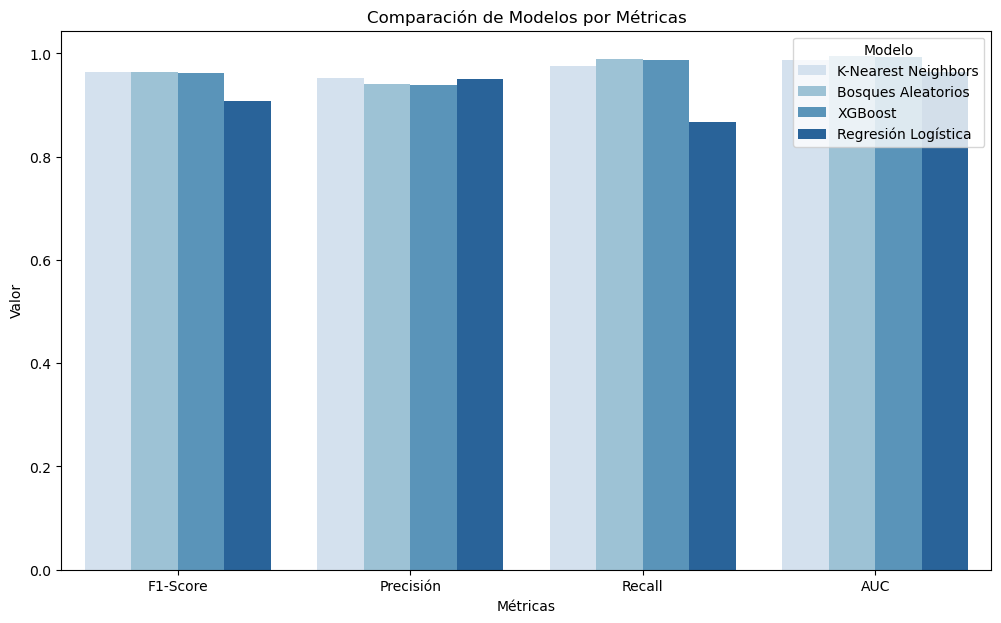

In [76]:
## Gráfico de barras para las métricas
plt.figure(figsize=(12, 7))
sns.barplot(data=resultados_df.melt(id_vars=["Modelo", "Mejores Hiperparámetros"], value_vars=["F1-Score", "Precisión", "Recall", "AUC"]),
            x="variable", y="value", hue="Modelo", palette="Blues")
plt.title("Comparación de Modelos por Métricas")
plt.ylabel("Valor")
plt.xlabel("Métricas")
plt.legend(title="Modelo")
plt.show()

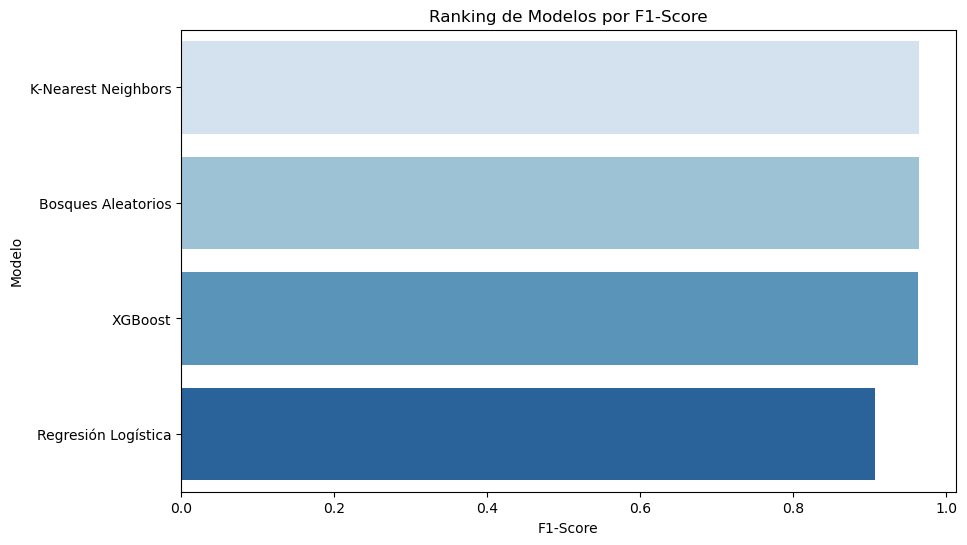

In [77]:
## Gráfico de ranking por F1-Score
plt.figure(figsize=(10, 6))
sns.barplot(data=resultados_df, x="F1-Score", y="Modelo", palette="Blues")
plt.title("Ranking de Modelos por F1-Score")
plt.xlabel("F1-Score")
plt.ylabel("Modelo")
plt.show()

# Conclusión

El modelo de Bosques Aleatorios demostró ser la solución más robusta y confiable para la detección de 
transacciones fraudulentas. Su capacidad para equilibrar un alto recall (0.998551), fundamental para 
minimizar fraudes no detectados, con una precisión sobresaliente (0.991539) que reduce los falsos 
positivos, lo convierte en una herramienta ideal para este contexto. Además, su flexibilidad en la 
selección de hiperparámetros y su escalabilidad lo hacen adecuado para manejar grandes volúmenes 
de datos transaccionales, garantizando un rendimiento óptimo en escenarios complejos y dinámicos 
como los de detección de fraude.

### Exportar las métricas del mejor modelo
Guarda las métricas del mejor modelo en un archivo (por ejemplo, JSON) para que puedan ser leídas por el dashboard:

In [78]:
# Obtener el directorio actual de trabajo
current_dir = os.getcwd()

# Subir un nivel desde notebooks para llegar a la carpeta raíz del proyecto
project_root = os.path.dirname(current_dir)

# Construir la ruta para guardar las métricas
output_path = os.path.join(project_root, 'data', 'best_model_metrics.json')

# Asegúrate de que la carpeta 'data' exista
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Seleccionar el mejor modelo basado en F1-Score
mejor_modelo_metrics = resultados_df.iloc[0]

# Crear un diccionario con las métricas relevantes
best_model_metrics = {
    "modelo": mejor_modelo_metrics["Modelo"],
    "precision": mejor_modelo_metrics["Precisión"],
    "recall": mejor_modelo_metrics["Recall"],
    "f1_score": mejor_modelo_metrics["F1-Score"],
    "auc": mejor_modelo_metrics["AUC"],
    "exactitud": mejor_modelo_metrics["Exactitud"]
}

# Guardar las métricas en un archivo JSON
with open(output_path, "w") as f:
    json.dump(best_model_metrics, f, indent=4)

print(f"Métricas del mejor modelo guardadas en: {output_path}")


Métricas del mejor modelo guardadas en: c:\Users\jadarve\OneDrive - Grupo Bancolombia\Bancolombia\MIAD\Despliegue de soluciones de analytics\Proyecto\fraud-detection\data\best_model_metrics.json


In [80]:
# Identificar el mejor modelo
mejor_modelo_nombre = resultados_df.iloc[0]["Modelo"]
print(f"Mejor modelo: {mejor_modelo_nombre}")


# Recuperar el mejor modelo
mejor_modelo_idx = next(i for i, d in enumerate(resultados) if d["Modelo"] == mejor_modelo_nombre)
mejor_modelo = modelos[mejor_modelo_nombre]

# Entrenar nuevamente con el mejor modelo y sus hiperparámetros óptimos
mejores_params = resultados[mejor_modelo_idx]["Mejores Hiperparámetros"]
mejor_modelo.set_params(**mejores_params)
mejor_modelo.fit(X_train, y_train)

# Guardar el modelo entrenado
joblib.dump(mejor_modelo, "best_model.joblib")
print("El mejor modelo se ha guardado como 'best_model.joblib'")

# Para usar el modelo guardado en cualquier otra parte del proyecto, puedes cargarlo con:
# Cargar el modelo guardado
#mejor_modelo = joblib.load("mejor_modelo.joblib")

# Hacer predicciones con el modelo
#y_pred = mejor_modelo.predict(nuevos_datos)


Mejor modelo: K-Nearest Neighbors
El mejor modelo se ha guardado como 'best_model.joblib'


# Referencias

Lopez-Rojas, Edgar Alonso ; Axelsson, Stefan

Banksim: A bank payments simulator for fraud detection research Inproceedings

26th European Modeling and Simulation Symposium, EMSS 2014, Bordeaux, France, pp. 144–152, Dime University of Genoa, 2014, ISBN: 9788897999324.

https://www.researchgate.net/publication/265736405_BankSim_A_Bank_Payment_Simulation_for_Fraud_Detection_Research